<img src="./kuzushiji.jpg" style="max-height:20em"></img>

Kuzushiji-MNIST dataset. The datasets are structured as train and test, consisting of images each with dimensions of (1,28,28), indicating that each example is a grayscale image with dimensions 28x28 pixels (1 is the number of channels in the image. For grayscale images, C = 1, while for color images, C = 3 (representing red, green, and blue channels)).
Both the train and test datasets have the same shapes and data types. so there are no issues with data format or compatibility for model training and testing.

You can see all dataset visualization in the separate file "./datasets-view.ipynb". First of all, let's look at 15 examples of each datset (5 from start, 5 from middle, and 5 from end) to compare them. What we can see from datasets visualisation:

Advantages of datasets:
- big enough;
- all train, test, and test2 datasets have labels (good for evaluation);
- all train, test, and test2 datasets have the same amount of labels (no class mismatch) and the same amount of images in each label (no imbalanced).

Disadvantages of datasets:
- test and test2 datasets include symbols not present in the train dataset (with reversed colors - white backgroung with black symbol). test dataset includes two completely different symbols types compare with train dataset;
- test2 dataset doesn't represent train dataset at all, but has the similar symbols as in the test dataset.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import random

In [16]:


# Define custom dataset
class SymbolDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.data = []
        self.labels = []

        for label in range(1, 7):  # Classes 1 to 6
            class_dir = os.path.join(self.root_dir, self.split, str(label))
            file_names = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
            for file_name in file_names:
                file_path = os.path.join(class_dir, file_name)
                self.data.append(file_path)
                self.labels.append(label-1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.load(self.data[idx])  # Load .npy image
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths
root_dir = "./"
train_dir = os.path.join(root_dir, "TRAIN")
test_dir = os.path.join(root_dir, "TEST")

# Data normalization
transform = transforms.Compose([
    transforms.Lambda(lambda x: x),  # No-op if images are already tensors
    transforms.Normalize((0.5,), (0.5,))
])

# Prepare datasets
train_dataset = SymbolDataset(root_dir, "TRAIN", transform=transform)
test_dataset = SymbolDataset(root_dir, "TEST", transform=transform)

# Split training into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define models
class VGGLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGLikeModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x




# Training function
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Visualization function
def visualize_samples(dataset, num_samples=10):
    plt.figure(figsize=(10, 5))
    indices = random.sample(range(len(dataset)), num_samples)  # Randomly sample indices
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.numpy().squeeze()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label + 1}")  # Convert back to 1-based indexing for visualization
        plt.axis('off')
    plt.show()

# Run models
num_classes = 6


Training VGG-like model
Epoch 1/10, Train Loss: 0.3054, Val Loss: 0.1097, Val Accuracy: 0.9663
Epoch 2/10, Train Loss: 0.1028, Val Loss: 0.0693, Val Accuracy: 0.9778
Epoch 3/10, Train Loss: 0.0649, Val Loss: 0.0582, Val Accuracy: 0.9842
Epoch 4/10, Train Loss: 0.0484, Val Loss: 0.0489, Val Accuracy: 0.9862
Epoch 5/10, Train Loss: 0.0357, Val Loss: 0.0599, Val Accuracy: 0.9833
Epoch 6/10, Train Loss: 0.0306, Val Loss: 0.0500, Val Accuracy: 0.9867
Epoch 7/10, Train Loss: 0.0247, Val Loss: 0.0493, Val Accuracy: 0.9879
Epoch 8/10, Train Loss: 0.0230, Val Loss: 0.0507, Val Accuracy: 0.9886
Epoch 9/10, Train Loss: 0.0169, Val Loss: 0.0553, Val Accuracy: 0.9871
Epoch 10/10, Train Loss: 0.0164, Val Loss: 0.0588, Val Accuracy: 0.9861


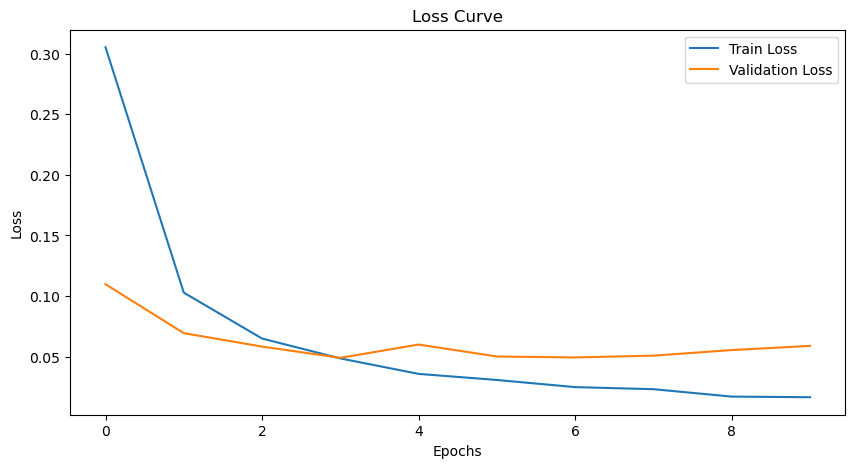

AttributeError: 'tuple' object has no attribute 'to'

In [17]:
print("Training VGG-like model")
vgg_model = VGGLikeModel(num_classes)
vgg_model = train_model(vgg_model, train_loader, val_loader)
evaluate_model(vgg_model, test_loader)

In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResNetBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=(2 if downsample else 1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if downsample or in_channels != out_channels:
            self.residual_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if downsample else 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual_connection = nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = nn.ReLU()(x)
        return x

class ResNetLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetLikeModel, self).__init__()
        self.layer1 = ResNetBlock(1, 64, downsample=True)
        self.layer2 = ResNetBlock(64, 128, downsample=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Training ResNet-like model
Epoch 1/10, Train Loss: 0.3908, Val Loss: 0.3908
Epoch 2/10, Train Loss: 0.1237, Val Loss: 0.1627
Epoch 3/10, Train Loss: 0.0776, Val Loss: 0.1423
Epoch 4/10, Train Loss: 0.0543, Val Loss: 0.1225
Epoch 5/10, Train Loss: 0.0402, Val Loss: 0.1136
Epoch 6/10, Train Loss: 0.0329, Val Loss: 0.0650
Epoch 7/10, Train Loss: 0.0240, Val Loss: 0.1556
Epoch 8/10, Train Loss: 0.0192, Val Loss: 0.1847
Epoch 9/10, Train Loss: 0.0128, Val Loss: 0.1376
Epoch 10/10, Train Loss: 0.0170, Val Loss: 0.1143
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.90      0.45      1000
           1       0.97      0.41      0.58      1000
           2       0.96      0.48      0.64      1000
           3       0.72      0.48      0.58      1000
           4       0.71      0.59      0.64      1000
           5       0.86      0.47      0.61      1000

    accuracy                           0.56      6000
   macro avg       0.75  

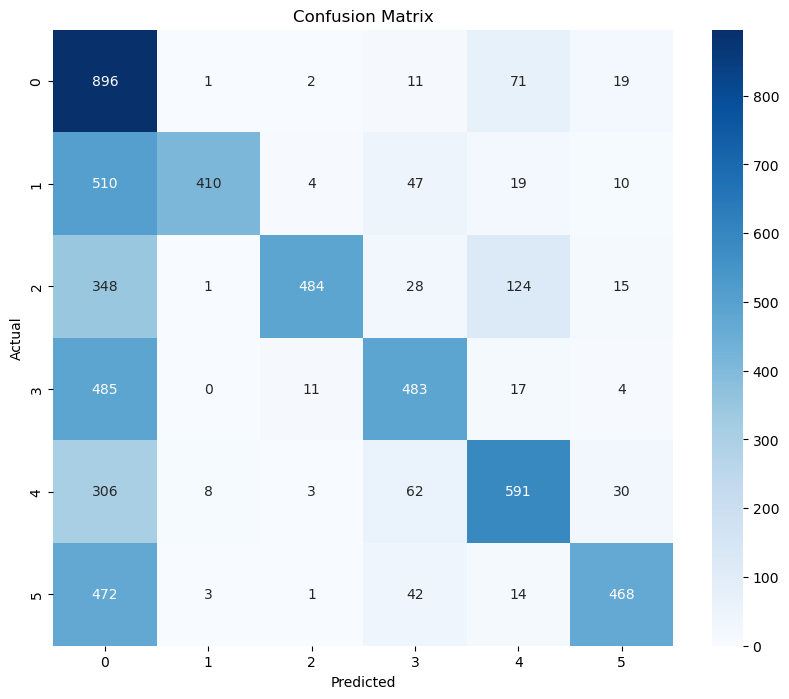

In [5]:
print("Training ResNet-like model")
resnet_model = ResNetLikeModel(num_classes)
resnet_model = train_model(resnet_model, train_loader, val_loader)
evaluate_model(resnet_model, test_loader)

In [6]:
class EfficientNetLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetLikeModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Training EfficientNet-like model
Epoch 1/10, Train Loss: 0.2753, Val Loss: 0.1149
Epoch 2/10, Train Loss: 0.1084, Val Loss: 0.0651
Epoch 3/10, Train Loss: 0.0777, Val Loss: 0.0607
Epoch 4/10, Train Loss: 0.0643, Val Loss: 0.0520
Epoch 5/10, Train Loss: 0.0494, Val Loss: 0.0496
Epoch 6/10, Train Loss: 0.0446, Val Loss: 0.0450
Epoch 7/10, Train Loss: 0.0369, Val Loss: 0.0532
Epoch 8/10, Train Loss: 0.0332, Val Loss: 0.0549
Epoch 9/10, Train Loss: 0.0306, Val Loss: 0.0505
Epoch 10/10, Train Loss: 0.0266, Val Loss: 0.0573
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63      1000
           1       0.90      0.47      0.62      1000
           2       0.80      0.48      0.60      1000
           3       0.80      0.48      0.60      1000
           4       0.49      0.58      0.53      1000
           5       0.37      0.80      0.50      1000

    accuracy                           0.57      6000
   macro avg       

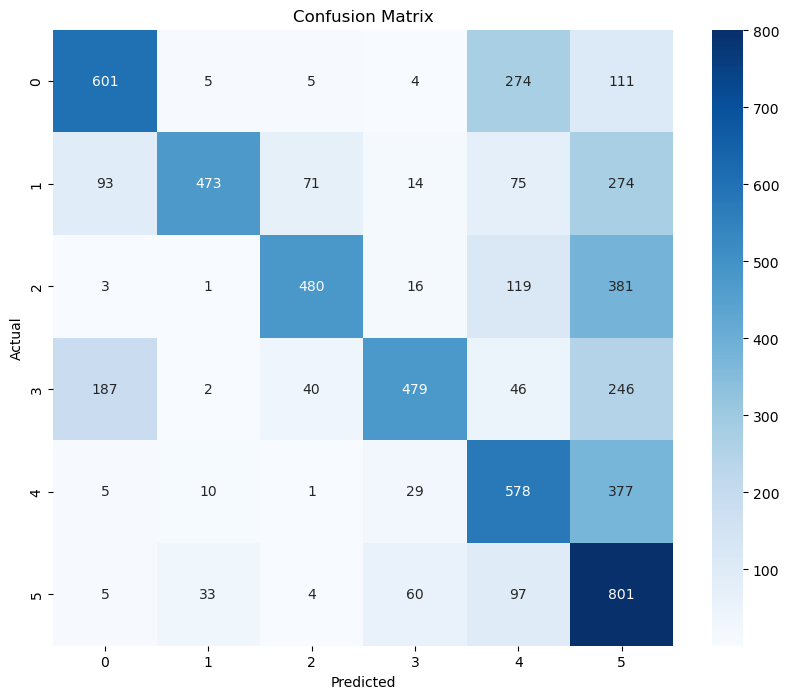

In [7]:

print("Training EfficientNet-like model")
efficientnet_model = EfficientNetLikeModel(num_classes)
efficientnet_model = train_model(efficientnet_model, train_loader, val_loader)
evaluate_model(efficientnet_model, test_loader)

In [11]:
class VGGResNetHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGResNetHybridModel, self).__init__()
        
        # VGG-like feature extraction
        self.vgg_features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # ResNet-like residual blocks
        self.res_block1 = ResNetBlock(64, 128, downsample=True)
        self.res_block2 = ResNetBlock(128, 256, downsample=True)
        
        # Placeholder for input features to the classifier
        self.flattened_size = None
        
        # Fully connected layers (set later dynamically)
        self.classifier = None
        self.num_classes = num_classes

    def forward(self, x):
        x = self.vgg_features(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        
        # Dynamically calculate flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.classifier = nn.Sequential(
                nn.Linear(self.flattened_size, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, self.num_classes),
            ).to(x.device)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


VGG and ResNet Hybrid model
Epoch 1/10, Train Loss: 0.2012, Val Loss: 0.0826
Epoch 2/10, Train Loss: 0.0546, Val Loss: 0.0521
Epoch 3/10, Train Loss: 0.0282, Val Loss: 0.0497
Epoch 4/10, Train Loss: 0.0205, Val Loss: 0.0563
Epoch 5/10, Train Loss: 0.0170, Val Loss: 0.0440
Epoch 6/10, Train Loss: 0.0096, Val Loss: 0.0401
Epoch 7/10, Train Loss: 0.0068, Val Loss: 0.0522
Epoch 8/10, Train Loss: 0.0104, Val Loss: 0.0500
Epoch 9/10, Train Loss: 0.0059, Val Loss: 0.0363
Epoch 10/10, Train Loss: 0.0012, Val Loss: 0.0334
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.79      0.60      1000
           1       0.77      0.47      0.59      1000
           2       0.93      0.48      0.63      1000
           3       0.59      0.51      0.55      1000
           4       0.62      0.52      0.56      1000
           5       0.42      0.65      0.51      1000

    accuracy                           0.57      6000
   macro avg       0.64 

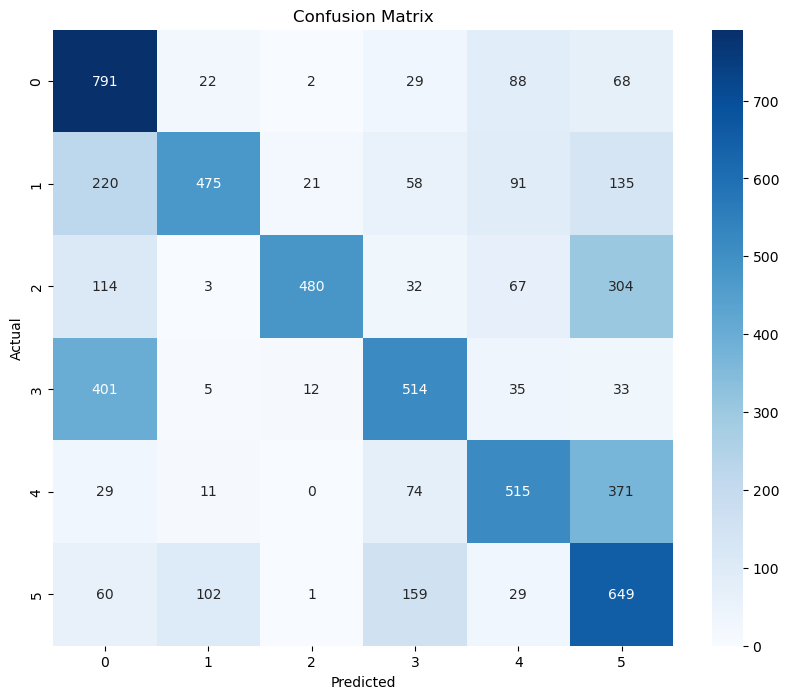

In [12]:
print("VGG and ResNet Hybrid model")
hybrid_model = VGGResNetHybridModel(num_classes)
hybrid_model = train_model(hybrid_model, train_loader, val_loader)
evaluate_model(hybrid_model, test_loader)

We have bad accuracy as expexed. What can we do:
1. Create new train dataset consisting of initial train dataset and initial train dataset with reversed color (change black background on white and black symbols on white).
2. Train model again using new train dataset.